In [1]:
from dolfin import *
import numpy as np

%matplotlib inline
from dolfin.plotting import plot

# Define input data
from ufl import SpatialCoordinate, inner, grad, lhs, rhs, dot, exp, Measure, dx, ds
from dolfin.fem import assemble_scalar

In [2]:
import dolfin
import dolfin.io
dolfin.__version__

'2018.2.0.dev0'

In [3]:
import meshio
# Read the file generated by gmsh
mesh = meshio.read("Models/poission_subdomain.msh")
points, cells, cell_data, field_data = mesh.points, mesh.cells, mesh.cell_data, mesh.field_data

In [4]:
field_data

{'LEFT': array([1, 1]),
 'TOP': array([2, 1]),
 'RIGHT': array([3, 1]),
 'BOTTOM': array([4, 1]),
 'DOMAIN': array([5, 2]),
 'OBSTACLE': array([6, 2])}

In [5]:
cell_data

{'line': {'gmsh:physical': array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])},
 'triangle': {'gmsh:physical': array([5, 5, 5, ..., 6, 6, 6])}}

In [6]:
meshio.write("Models/poisson_subdomain_mesh.xdmf", 
             meshio.Mesh(
                points=points[:,:2],# Converting to 2D
                cells={"triangle": cells["triangle"]},
                cell_data={"triangle": {"subdomain": cell_data["triangle"]["gmsh:physical"]}}
             )
            )

In [7]:
meshio.write("Models/poisson_subdomain_boundary.xdmf", meshio.Mesh(
    points=points[:,:2],# Converting to 2D
    cells={"line": cells["line"]},
    cell_data={"line": {"boundaries": cell_data["line"]["gmsh:physical"]}}
))

In [8]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world, "Models/poisson_subdomain_mesh.xdmf") as xdmf_infile:
    mesh = xdmf_infile.read_mesh(dolfin.MPI.comm_world, dolfin.cpp.mesh.GhostMode.none)
    mvc_subdomain = xdmf_infile.read_mvc_size_t(mesh, "subdomain")
domains = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc_subdomain, 1)

In [9]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world, "Models/poisson_subdomain_boundary.xdmf") as xdmf_infile:
    mvc_boundaries = xdmf_infile.read_mvc_size_t(mesh, "boundaries")
boundaries = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc_boundaries, 0)

    #tags = xdmf_infile.read_tags()
#print(tags)

In [10]:
min(domains.array())

5

In [11]:
domains.array()

array([5, 5, 5, ..., 6, 6, 6], dtype=uint64)

In [12]:
mesh.num_cells()

6550

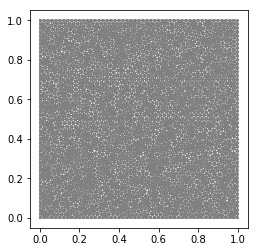

In [13]:
plot(mesh)

In [14]:
a0 = 1.0
a1 = 0.01
x = SpatialCoordinate(mesh)
g_L = exp(- 10*(- pow(x[1] - 0.5, 2)))
g_R = 1.0
f = 1.0

In [15]:
# Define function space and basis functions
V = FunctionSpace(mesh, ("CG", 2))
u = TrialFunction(V)
v = TestFunction(V)

In [16]:
u5 = Function(V)
with u5.vector().localForm() as bc_local:
    bc_local.set(5.0)

u0 = Function(V)
with u0.vector().localForm() as bc_local:
    bc_local.set(0.0)

In [17]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, u5, boundaries.where_equal(2)),
       DirichletBC(V, u0, boundaries.where_equal(4))]

In [18]:
dx = dx(subdomain_data=domains)
ds = ds(subdomain_data=boundaries)

In [19]:
# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(5) + inner(a1*grad(u), grad(v))*dx(6)
     - g_L*v*ds(1) - g_R*v*ds(3)
     - f*v*dx(5) - f*v*dx(6))

In [20]:
# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

In [21]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

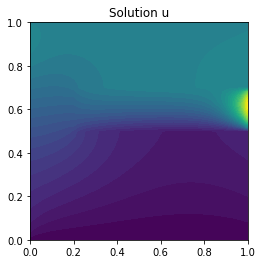

In [22]:
plot(u, title="Solution u")

In [23]:
bb_tree = cpp.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
u([0.5, 0.5], bb_tree)[0]

1.0221479056506502

In [24]:
max(u.vector().array)

11.269341773606898

In [25]:
from numpy import linspace
from matplotlib.pyplot import plot

xval = linspace(0,1,10)

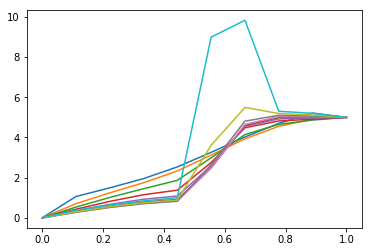

In [26]:
for x in xval:
    yval=[u([x, y], bb_tree)[0] for y in xval]
    plot(xval, yval)

In [18]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(2)
v1 = assemble_scalar(m1)
print("\int grad(u) * n ds(2) = ", v1)

\int grad(u) * n ds(2) =  0.0


In [19]:
# Evaluate integral of u over the obstacle
m2 = u*dx(1)
v2 = assemble_scalar(m2)
print("\int u dx(1) = ", v2)

\int u dx(1) =  0.4752519801053826


In [21]:
gu=grad(u)
gu

Grad(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 2)), 8))

In [22]:
#plot(gu, title="Projected grad(u)")